In [100]:
%reset -f
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from upsetplot import UpSet,  generate_counts, from_memberships, plot, from_indicators
import logomaker as lm
import tempfile
import shutil
import subprocess
from Bio import SeqIO
import tempfile
import subprocess
from Bio import SeqIO
from collections import Counter
import pandas as pd
import logomaker
import math
import numpy as np
import os


%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['figure.dpi']= 300

sns.set_style('ticks')
# sns.set_context('paper')


In [101]:
# INPUT

# dir_input='/Users/isaccocenacchi/Desktop/Tirocinio/out/MAGs_CRISPRtools'
dir_input='/home/isacco.cenacchi/data/Tirocinio/out/MAGs_CRISPRtools'

# Caricamento dei dati
input=f'{dir_input}/MAGs_tools_comparison.tsv'
cas=f'{dir_input}/Aug19_cas_operons_filtered_CRISPRtools.tsv'

# Viral Datasets
viral_datasets={}
viral_datasets['VSC5']='/shares/CIBIO-Storage/CM/scratch/users/matteo.ciciani/13new_pamsearch/viral_datasets/allVCs/VSC5.fna'
viral_datasets['GPD']='/shares/CIBIO-Storage/CM/scratch/users/matteo.ciciani/13new_pamsearch/viral_datasets/Gut_Phage_Database/GPD.fna'
viral_datasets['MGV']='/shares/CIBIO-Storage/CM/scratch/users/matteo.ciciani/13new_pamsearch/viral_datasets/Metagenomic_Gut_Virus/MGV.fna'

# dir save figs
dir_save=f'{dir_input}/figs'
os.makedirs(dir_save, exist_ok=True)

In [ ]:
# Dataframe con i dati dei CRISPR 
df=pd.read_csv(input, sep='\t', index_col=False, header=0)
# Dataframe con i dati dei cas operon + una colonna con il numero di Spacers che ogni cas operon ha vicino (entro 10kb)
df_cas=pd.read_csv(cas, sep='\t', index_col=False, header=0)

# Calcolo delle lunghezze delle spacers e dei repeat
df['SP_lens'] = df['Spacers'].apply(lambda x: [len(spacer) for spacer in x.split(',')])
df['DR_lens'] = df['Repeats'].apply(lambda x: [len(dr) for dr in x.split(',')])
# Calcolo delle mediane
df['median_DR_len'] = df['DR_lens'].apply(lambda x: pd.Series(x).median())
df['median_SP_len'] = df['SP_lens'].apply(lambda x: pd.Series(x).median())
# Calcolo max e min DR e SP
df['max_DR_len'] = df['DR_lens'].apply(lambda x: pd.Series(x).max())
df['min_DR_len'] = df['DR_lens'].apply(lambda x: pd.Series(x).min())
df['max_SP_len'] = df['SP_lens'].apply(lambda x: pd.Series(x).max())
df['min_SP_len'] = df['SP_lens'].apply(lambda x: pd.Series(x).min())

# Funzione per calcolare il coefficiente di variazione
def coeff_var(x):
    return pd.Series(x).std() / pd.Series(x).mean()

# Deviazione standard
df['std_DR_len'] = df['DR_lens'].apply(lambda x: pd.Series(x).std())
df['std_SP_len'] = df['SP_lens'].apply(lambda x: pd.Series(x).std())

# Coefficiente di variazione
df['cv_DR_len'] = df['DR_lens'].apply(coeff_var)
df['cv_SP_len'] = df['SP_lens'].apply(coeff_var)

# Rapporto tra la lunghezza minima e massima
df['minmax_DR_ratio'] = df['DR_lens'].apply(lambda x: min(x) / max(x) if max(x) != 0 else 0)

# Colonna con true se il CRISPR ha un cas operon vicino (entro 10kb) altrimenti false
df['Nearby_Cas'] = (df['Cas_0-1000'] > 0) | (df['Cas_1000-10000'] > 0)

# Colonna per ottenere i repeat unici come set
df['Unique_DR'] = df['Repeats'].apply(lambda x: set(x.split(',')))

# Separare i tool, esplodendo le righe in base ai tool multipli
df_exploded = df.assign(ToolCodename=df['ToolCodename'].str.split(',')).explode('ToolCodename').sort_values(by='ToolCodename')


# Dataframe Raggruppato per ID

# Funzione per verificare l'uniformità e mantenere il valore se è uguale
def verifica_uniformita(x):
    if x.nunique() == 1:  # Se ci sono valori unici
        return x.iloc[0]  # Mantieni il primo
    else:
        return None  # Restituisci None se non sono uguali

# Funzione che appiattisce una lista di stringhe (o liste di stringhe), rimuove duplicati, ordina e restituisce una stringa separata da virgole.
def unisci_e_ordina(x):
    # appiattire la lista di liste in un unica lista di stringhe
    x = [item for subset in x for item in subset.split(',')]
    return ','.join(sorted(set(x)))

df_id = df.groupby('ID', as_index=False).agg({
    'MAG': verifica_uniformita,
    'Contig': verifica_uniformita,
    'Start': 'min',
    'End': 'max',
    'Repeats': lambda x: ','.join(x),
    'Spacers':unisci_e_ordina,
    'Cas_0-1000': 'max',
    'Cas_1000-10000': 'max',
    'Cas_>100000': 'max',
    'Cas_overlayed': 'max',
    'ToolCodename': unisci_e_ordina,
    'Nearby_Cas': 'max',
    }) 

df_id['Cas_0-10000']=df_id['Cas_0-1000']+df_id['Cas_1000-10000']
df_id['Num_DR'] = df_id['Repeats'].apply(lambda x: len(x.split(',')))
df_id['Num_SP'] = df_id['Spacers'].apply(lambda x: len(x.split(',')))

# Funzione per calcolare la similarità tra i repeat

# Data un'insieme di sequenze (allineate) calcola la matrice delle informazioni
def make_info_df(seqs):
    # Create a list of Counters, one for each position in the alignment
    counters = [Counter() for i in range(len(seqs[0]))]
    for i in range(len(counters)):
        for seq in seqs:
            if i < len(seq):
                counters[i][seq[i]] +=1
    # Create a matrix of frequencies
    freqs = pd.DataFrame(counters).fillna(0)
    # Create a matrix of probabilities
    probs = freqs.divide(freqs.sum(axis=1), axis=0).fillna(1.0/freqs.shape[1])
    # Check that the probabilities sum to 1.0
    if not all(probs.sum(axis=1).apply(lambda x: math.isclose(x, 1.0))):
        raise ValueError
    # Transform the matrix of probabilities into a matrix of information
    info = logomaker.transform_matrix(probs, from_type='probability',
        to_type='information')
    # Normalize the matrix of information
    # (re-become probabilities)
    info = info.divide(np.log2(info.shape[1]))
    return info


def DR_Similarity(repeats):
    repeats = repeats.split(',')

    # Crea il file FASTA con le sequenze
    with tempfile.NamedTemporaryFile("w", suffix=f".fasta", delete=True, delete_on_close = False) as input_file, tempfile.NamedTemporaryFile("wb", suffix=f".aln", delete=True, delete_on_close = False) as output_file:
        for i, seq in enumerate(repeats):
            input_file.write(f">Sequence_{i+1}\n{seq}\n")
        input_file.close()

        # Esegui il comando Muscle o Mafft 
        if len(repeats) < 100:
            subprocess.run(["muscle", "-align", input_file.name, "-output", output_file.name], 
                    stdout=subprocess.DEVNULL, 
                    stderr=subprocess.DEVNULL, 
                    check=True)
        else:
            subprocess.run(["mafft", input_file.name], 
                        stdout=output_file, 
                        stderr=subprocess.DEVNULL, 
                        check=True)
            output_file.close()

        # copia il file temporaneo in un file permanente 'sequences.fasta' con python shutil
        # shutil.copy(input_file.name, "sequences.fasta")
        # shutil.copy(output_file.name, "alignment.aln")
        
        # Leggi l'allineamento
        seqs = [str(rec.seq).strip().upper() for rec in SeqIO.parse(output_file.name, "fasta")]

    # create probability matrix (from information matrix)
    alignment_df = make_info_df(seqs)

    # return the sum of the information content of each position (Site Entropy)
    return alignment_df.sum(axis=1).mean()

df_id["DR_Similarity"] = df_id['Repeats'].apply(lambda x: DR_Similarity(x))

df_id_exploded = df_id.assign(ToolCodename=df_id['ToolCodename'].str.split(',')).explode('ToolCodename').sort_values(by='ToolCodename')

# Salvo i dataframe in file tsv

df['Unique_DR'] = df['Unique_DR'].apply(lambda x: ','.join(x))
df_exploded['Unique_DR'] = df_exploded['Unique_DR'].apply(lambda x: ','.join(x))

df.to_csv(f'{dir_input}/CRISPR_toolComparison.tsv', sep='\t', index=False, )
df_exploded.to_csv(f'{dir_input}/CRISPR_toolComparison_exploded.tsv', sep='\t', index=False)
df_id.to_csv(f'{dir_input}/CRISPR_ID_toolComparison.tsv', sep='\t', index=False)
df_id_exploded.to_csv(f'{dir_input}/CRISPR_ID_toolComparison_exploded.tsv', sep='\t', index=False)

df['Unique_DR'] = df['Unique_DR'].apply(lambda x: set(x.split(',')))
df_exploded['Unique_DR'] = df_exploded['Unique_DR'].apply(lambda x: set(x.split(',')))

In [105]:
# Recupero i dataframe gia creati

df=pd.read_csv(f'{dir_input}/CRISPR_toolComparison.tsv', sep='\t', index_col=False, header=0, dtype={'MAG':str, 'Contig':str, 'Repeats':str, 'Spacers':str, 'ToolCodename':str, 'Cas_0-1000':int, 'Cas_1000-10000':int, 'Cas_>100000':int, 'Cas_overlayed':int, 'Nearby_Cas':bool, 'SP_lens':str, 'DR_lens':str, 'median_DR_len':float, 'median_SP_len':float, 'max_DR_len':int, 'min_DR_len':int, 'max_SP_len':int, 'min_SP_len':int, 'std_DR_len':float, 'std_SP_len':float, 'cv_DR_len':float, 'cv_SP_len':float, 'minmax_DR_ratio':float, 'Unique_DR':str})
df['Unique_DR']=df['Unique_DR'].apply(lambda x: x.split(','))
df_exploded=pd.read_csv(f'{dir_input}/CRISPR_toolComparison_exploded.tsv', sep='\t', index_col=False, header=0, dtype={'ID':str, 'MAG':str, 'Contig':str, 'Repeats':str, 'Spacers':str, 'ToolCodename':str, 'Cas_0-1000':int, 'Cas_1000-10000':int, 'Cas_>100000':int, 'Cas_overlayed':int, 'Nearby_Cas':bool, 'SP_lens':str, 'DR_lens':str, 'median_DR_len':float, 'median_SP_len':float, 'max_DR_len':int, 'min_DR_len':int, 'max_SP_len':int, 'min_SP_len':int, 'std_DR_len':float, 'std_SP_len':float, 'cv_DR_len':float, 'cv_SP_len':float, 'minmax_DR_ratio':float, 'Unique_DR':str})
df_exploded['Unique_DR']=df_exploded['Unique_DR'].apply(lambda x: x.split(','))
df_id=pd.read_csv(f'{dir_input}/CRISPR_ID_toolComparison.tsv', sep='\t', index_col=False, header=0, dtype={'ID':str, 'MAG':str, 'Contig':str, 'Repeats':str, 'Spacers':str, 'ToolCodename':str, 'Cas_0-1000':int, 'Cas_1000-10000':int, 'Cas_>100000':int, 'Cas_overlayed':int, 'Nearby_Cas':bool, 'SP_lens':str, 'DR_lens':str, 'median_DR_len':float, 'median_SP_len':float, 'max_DR_len':int, 'min_DR_len':int, 'max_SP_len':int, 'min_SP_len':int, 'std_DR_len':float, 'std_SP_len':float, 'cv_DR_len':float, 'cv_SP_len':float, 'minmax_DR_ratio':float, 'Cas_0-10000':int, 'Num_DR':int, 'Num_SP':int, 'DR_Similarity':float})
df_id_exploded=pd.read_csv(f'{dir_input}/CRISPR_ID_toolComparison_exploded.tsv', sep='\t', index_col=False, header=0, dtype={'ID':str, 'MAG':str, 'Contig':str, 'Repeats':str, 'Spacers':str, 'ToolCodename':str, 'Cas_0-1000':int, 'Cas_1000-10000':int, 'Cas_>100000':int, 'Cas_overlayed':int, 'Nearby_Cas':bool, 'SP_lens':str, 'DR_lens':str, 'median_DR_len':float, 'median_SP_len':float, 'max_DR_len':int, 'min_DR_len':int, 'max_SP_len':int, 'min_SP_len':int, 'std_DR_len':float, 'std_SP_len':float, 'cv_DR_len':float, 'cv_SP_len':float, 'minmax_DR_ratio':float, 'Cas_0-10000':int, 'Num_DR':int, 'Num_SP':int, 'DR_Similarity':float})

# Dataframe con i dati dei cas operon + una colonna con il numero di Spacers che ogni cas operon ha vicino (entro 10kb)
df_cas=pd.read_csv(cas, sep='\t', index_col=False, header=0)

In [103]:
# Lista dei tool e delle statistiche
tools = list(df_exploded['ToolCodename'].unique())
stats={'median_DR_len':'Lunghezza Mediana DR',
       'median_SP_len':'Lunghezza Mediana SP',
       'min_DR_len':'Lunghezza Minima DR',
       'max_DR_len':'Lunghezza Massima DR',
       'min_SP_len':'Lunghezza Minima SP',
       'max_SP_len':'Lunghezza Massima SP',
       'std_DR_len':'Deviazione Standard della Lunghezza DR',
       'std_SP_len':'Deviazione Standard della Lunghezza SP',
       'cv_DR_len':'Coeffiente di Variazione della Lunghezza DR',
       'cv_SP_len':'Coeffiente di Variazione della Lunghezza SP',
       'minmax_DR_ratio':'Rapporto lunghezza minima/massima DR'}

In [ ]:
# MAKE DB of SPACERS and Calculate how many spacers are in the viral dataset


# Inizializza le colonne per tutti i dataset virali se non esistono già
for viral_dataset in viral_datasets.keys():
    if f'nSP_match_{viral_dataset}' not in df_exploded.columns:
        df_exploded[f'nSP_match_{viral_dataset}'] = 0

# Ciclo per ogni tool
# (Filtra le righe dove Nearby_Cas è True) e Raggruppa per ToolCodename
for tool, group in df_exploded.groupby('ToolCodename'):
    # Genera il nome del file in base al ToolCodename
    file_name = f"{dir_input}/spacers_{tool}.fna"
    with open(file_name, 'w') as f:
        # Itera su ogni riga del gruppo
        for idx, row in group.iterrows():
            # Estrai le informazioni per l'annotazione
            MAG = row['MAG']
            Contig = row['Contig']
            Start = row['Start']
            End = row['End']
            
            # Dividi la colonna Spacers (assicurandoti che sia una stringa)
            spacers = [sp.strip() for sp in str(row['Spacers']).split(',') if sp.strip()]
            
            # Scrivi ogni spacer con un numero sequenziale
            for i, spacer in enumerate(spacers, start=1):
                header = f">{MAG}-{Contig}-{Start}-{End}-s{i}"
                f.write(header + "\n")
                f.write(spacer + "\n")

    # Run BLASTN per ogni dataset virale
    for viral_dataset, viral_dataset_path in viral_datasets.items():
        output_file = f"{dir_input}/blastn_{tool}_{viral_dataset}.tsv"
        
        # subprocess.run(["blastn", "-query", file_name, "-db", viral_dataset_path, "-out", output_file, "-outfmt", "6  qseqid sseqid pident nident qlen slen length mismatch gapopen qseq sseq qstart qend sstart send evalue sstrand bitscore", "-num_threads", "16"], 
        #                stdout=subprocess.DEVNULL, 
        #                stderr=subprocess.DEVNULL,
        #                check=True)
    
        # Read BLASTN output
        try:
            df_blastn = pd.read_csv(output_file, sep='\t', header=None, 
                                    names=["qseqid", "sseqid", "pident", "nident", "qlen", "slen", "length", "mismatch", "gapopen", "qseq", "sseq", "qstart", "qend", "sstart", "send", "evalue", "sstrand", "bitscore"],
                                    dtype={"qseqid":str, "sseqid":str, "pident":float, "nident":int, "qlen":int, "slen":int, "length":int, "mismatch":int, "gapopen":int, "qseq":str, "sseq":str, "qstart":int, "qend":int, "sstart":int, "send":int, "evalue":float, "sstrand":str, "bitscore":float})
        except pd.errors.EmptyDataError:
            # Se non ci sono risultati di BLAST, continua con il prossimo dataset
            print(f"Nessun risultato BLAST per {tool} contro {viral_dataset}")
            continue

        # Filtro i risultati di blastn per avere solo le corrispondenze perfette
        def filter_matches(blast_result, max_n_diff=3): # input blastn result dataframe
            near_perfect_matches = blast_result[
                blast_result['qlen']-blast_result['nident'] <= max_n_diff]
            full_len_matches = near_perfect_matches[
                near_perfect_matches['length']==near_perfect_matches['qlen']]
            return full_len_matches

        df_alignment_filtered = filter_matches(df_blastn)
        
        # Se non ci sono match dopo il filtraggio, continua con il prossimo dataset
        if df_alignment_filtered.empty:
            print(f"Nessun match filtrato per {tool} contro {viral_dataset}")
            continue

        # Apro qseqid per riottenere MAG, Contig, Start e End
        df_alignment_filtered['MAG'] = df_alignment_filtered['qseqid'].apply(lambda x: x.split('-')[0])
        df_alignment_filtered['Contig'] = df_alignment_filtered['qseqid'].apply(lambda x: x.split('-')[1])
        df_alignment_filtered['Start'] = df_alignment_filtered['qseqid'].apply(lambda x: int(x.split('-')[2]))
        df_alignment_filtered['End'] = df_alignment_filtered['qseqid'].apply(lambda x: int(x.split('-')[3]))

        # Funzione per verificare l'uniformità e mantenere il valore se è uguale
        def verifica_uniformita(x):
            if x.nunique() == 1:  # Se ci sono valori unici
                return x.iloc[0]  # Mantieni il primo
            else:
                return None  # Restituisci None se non sono uguali

        # Raggruppo quelli con lo stesso spacer
        df_spacer_matched = df_alignment_filtered.groupby('qseqid').agg({
            'sseqid': lambda x: ','.join(x), 
            'MAG': verifica_uniformita, 
            'Contig': verifica_uniformita, 
            'Start': verifica_uniformita, 
            'End': verifica_uniformita})

        # Aggiungo il conteggio di quanti elementi sono stati raggruppati per ogni spacer
        df_spacer_matched['num_matches'] = df_alignment_filtered.groupby('qseqid').size()

        # Raggruppo quelli con lo stesso CRISPR
        df_crispr_matched = df_spacer_matched.groupby(['MAG', 'Contig', 'Start', 'End'], as_index=False).agg({
            'MAG': verifica_uniformita,
            'Contig': verifica_uniformita,
            'Start': verifica_uniformita,
            'End': verifica_uniformita,
            'sseqid': lambda x: ','.join(x), 
            'num_matches': lambda x: ','.join(x.astype(str))
            })

        # Aggiungo il conteggio di quanti elementi sono stati raggruppati per ogni CRISPR
        df_crispr_matched['num_spacer_matched'] = df_crispr_matched['num_matches'].apply(lambda x: len(x.split(',')))

        # Effettua il merge solo sul subset filtrato su ToolCodename e aggiungi solo la colonna 'num_spacer_matched'
        df_merged = df_exploded[df_exploded['ToolCodename'] == tool].copy()
        df_merged = df_merged.merge(
            df_crispr_matched[['MAG', 'Contig', 'Start', 'End', 'num_spacer_matched']], 
            on=['MAG', 'Contig', 'Start', 'End'], 
            how='left'
        )

        # Crea un indice condizionale per selezionare le righe da aggiornare
        mask = (df_exploded['ToolCodename'] == tool) & (
            df_exploded['MAG'].isin(df_merged['MAG']) & 
            df_exploded['Contig'].isin(df_merged['Contig']) & 
            df_exploded['Start'].isin(df_merged['Start']) & 
            df_exploded['End'].isin(df_merged['End'])
        )
        
        # Crea un dizionario di mappatura per aggiornare in modo efficiente
        update_dict = {}
        for idx, row in df_merged.iterrows():
            if pd.notna(row['num_spacer_matched']):  # Aggiungi solo se non è NaN
                key = (row['MAG'], row['Contig'], row['Start'], row['End'])
                update_dict[key] = row['num_spacer_matched']
        
        # Aggiorna il dataframe originale utilizzando il dizionario
        for idx, row in df_exploded[mask].iterrows():
            key = (row['MAG'], row['Contig'], row['Start'], row['End'])
            if key in update_dict:
                df_exploded.at[idx, f'nSP_match_{viral_dataset}'] = update_dict[key]

        # Riempi i valori NaN con 0 solo per le righe del tool corrente
        mask_tool = df_exploded['ToolCodename'] == tool
        df_exploded.loc[mask_tool, f'nSP_match_{viral_dataset}'] = df_exploded.loc[mask_tool, f'nSP_match_{viral_dataset}'].fillna(0)

        print(f"Aggiornamento completato per {tool} contro {viral_dataset}")


# Salvo il dataframe in file tsv
# df_exploded['Unique_DR'] = df_exploded['Unique_DR'].apply(lambda x: ','.join(x))
# df_exploded.to_csv(f'{dir_input}/CRISPR_toolComparison_exploded.tsv', sep='\t', index=False)
# df_exploded['Unique_DR'] = df_exploded['Unique_DR'].apply(lambda x: set(x.split(',')))

Aggiornamento completato per CRISPRDetect3_cpu contro VSC5
Aggiornamento completato per CRISPRDetect3_cpu contro GPD
Aggiornamento completato per CRISPRDetect3_cpu contro MGV
Aggiornamento completato per CRISPRDetect3_nocpu contro VSC5
Aggiornamento completato per CRISPRDetect3_nocpu contro GPD
Aggiornamento completato per CRISPRDetect3_nocpu contro MGV
Aggiornamento completato per minced_Default contro VSC5
Aggiornamento completato per minced_Default contro GPD
Aggiornamento completato per minced_Default contro MGV
Aggiornamento completato per minced_Relaxed contro VSC5
Aggiornamento completato per minced_Relaxed contro GPD
Aggiornamento completato per minced_Relaxed contro MGV
Aggiornamento completato per pilercr_Default contro VSC5
Aggiornamento completato per pilercr_Default contro GPD
Aggiornamento completato per pilercr_Default contro MGV
Aggiornamento completato per pilercr_Relaxed contro VSC5
Aggiornamento completato per pilercr_Relaxed contro GPD
Aggiornamento completato per p

/tmp/ipykernel_1438920/354968413.py:155: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_1438920/354968413.py:155: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_1438920/354968413.py:155: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')


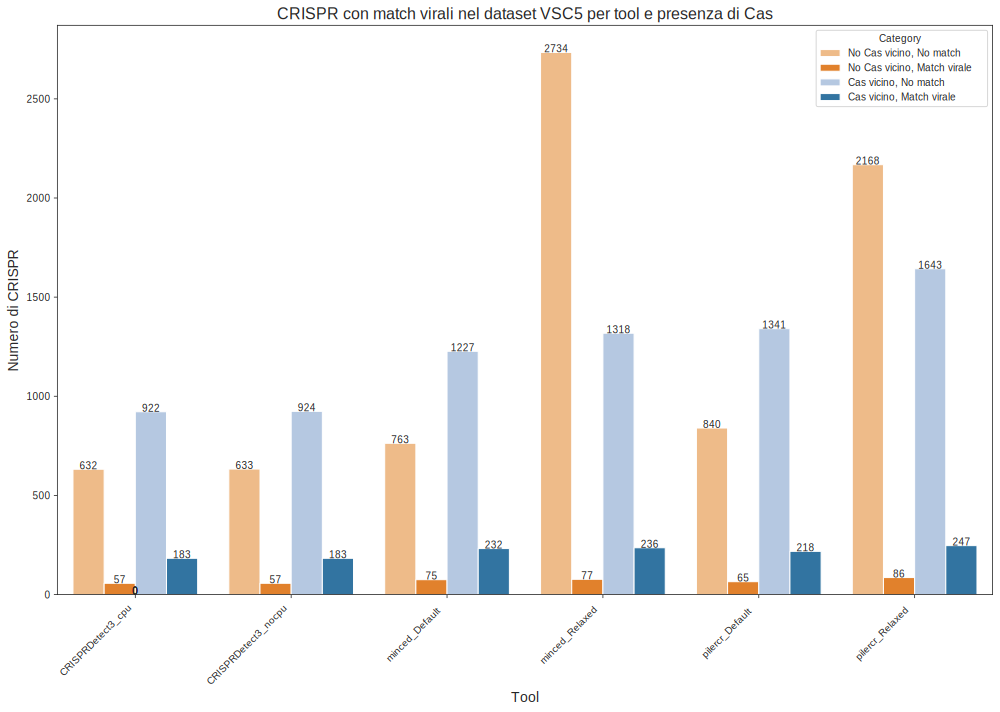

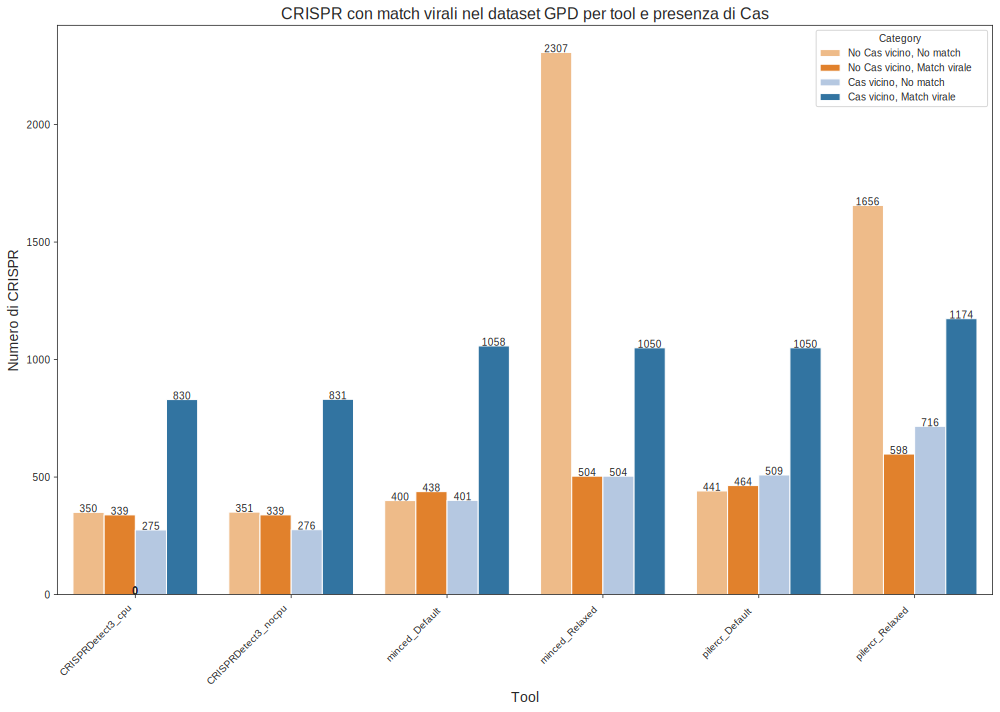

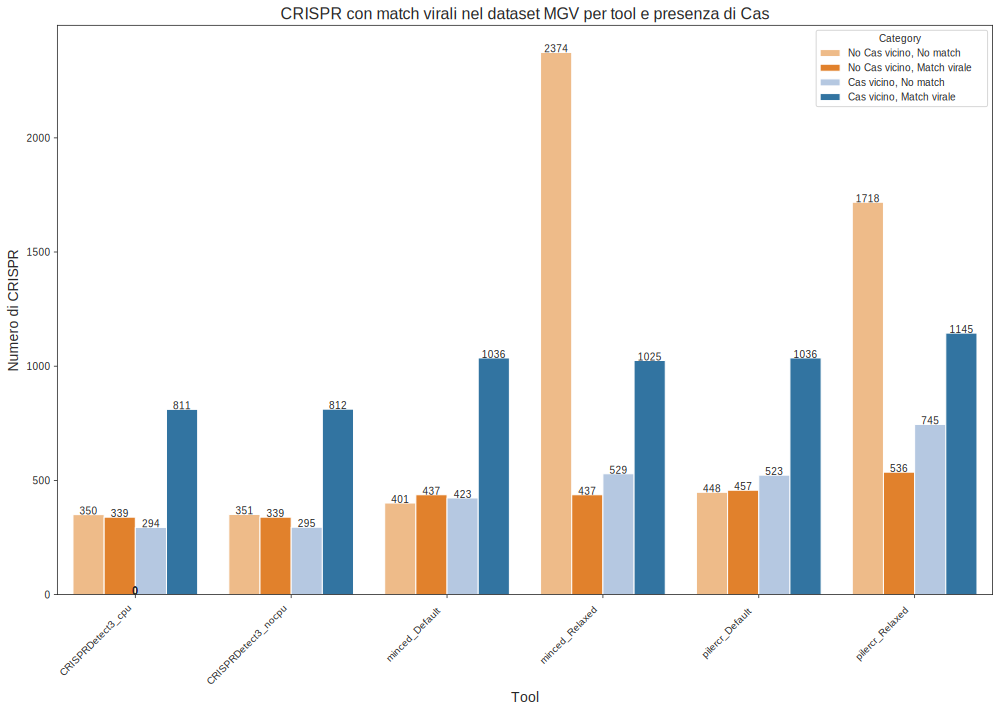

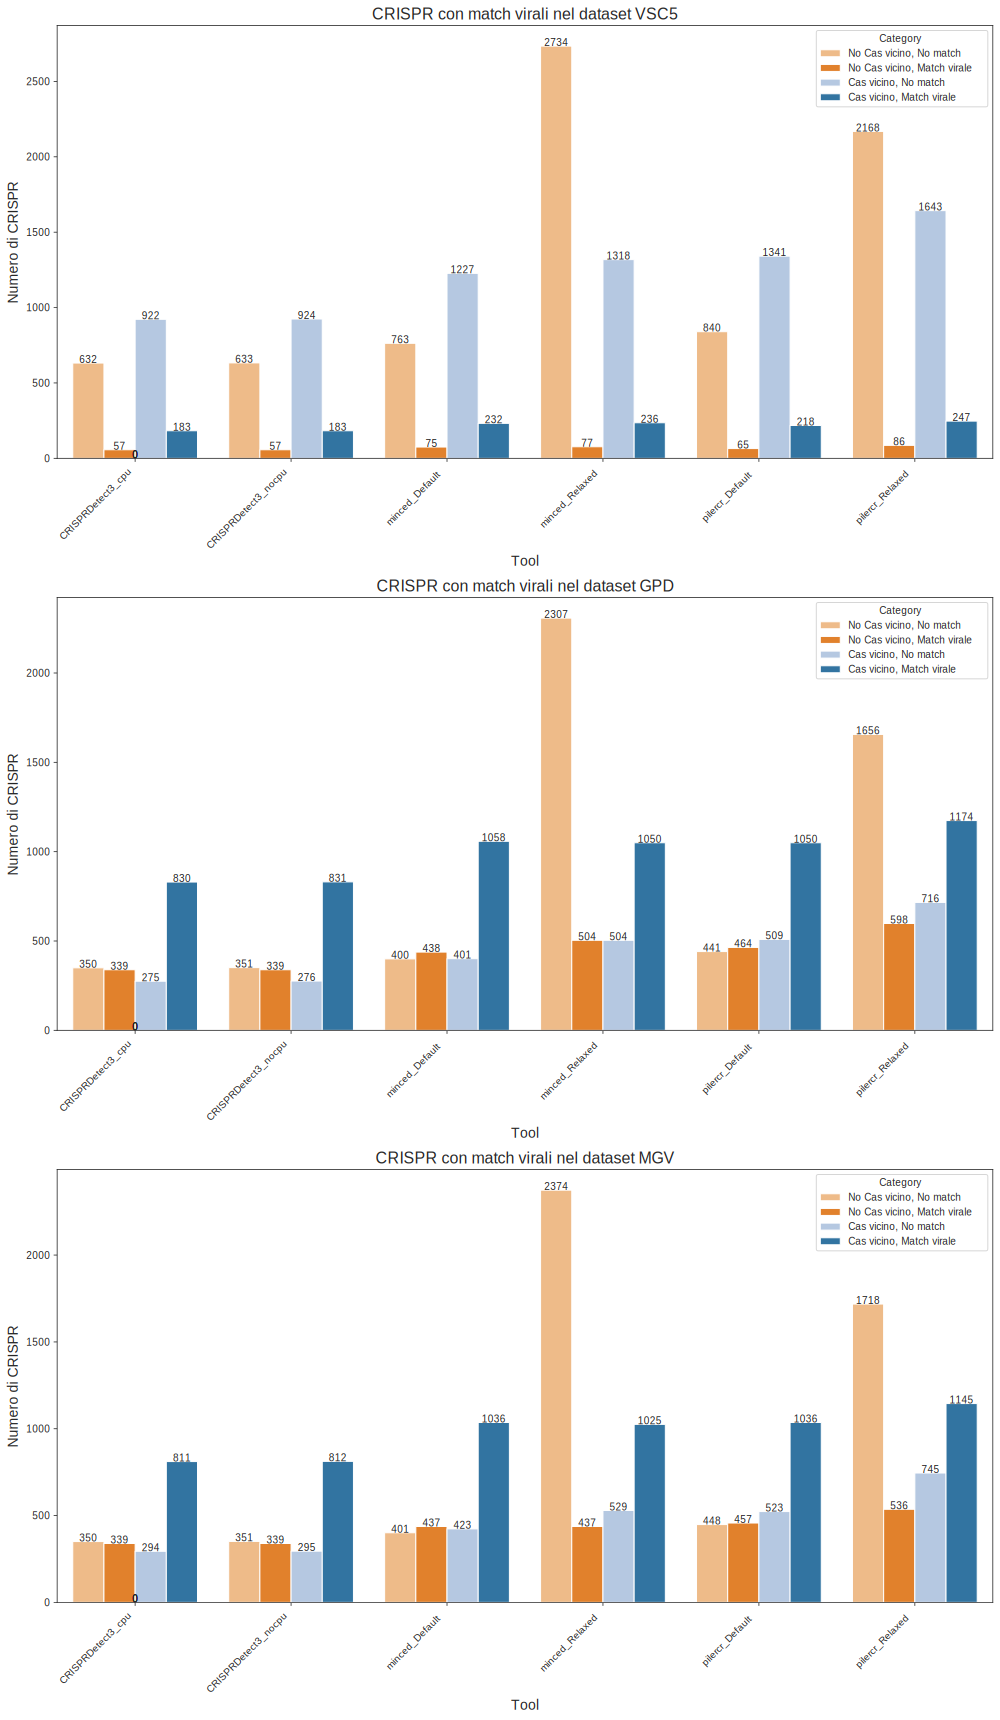

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Funzione per creare il grafico dei match virali per tool e presenza di Cas
def plot_crispr_viral_matches(df, viral_dataset, figsize=(14, 10)):
    """
    Crea un grafico che mostra il numero di CRISPR per tool che hanno match virali,
    distinguendo tra quelli con e senza Cas operon vicini.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame contenente i dati CRISPR
    viral_dataset : str
        Nome del dataset virale da analizzare ('VSC5', 'GPD', o 'MGV')
    figsize : tuple
        Dimensioni del grafico
        
    Returns:
    --------
    fig, ax : matplotlib figure e axes
    """
    # Verifica che il dataset virale sia valido
    valid_datasets = ['VSC5', 'GPD', 'MGV']
    if viral_dataset not in valid_datasets:
        raise ValueError(f"Dataset virale deve essere uno tra {', '.join(valid_datasets)}")
    
    # Crea una colonna che indica se ci sono match virali
    match_column = f'nSP_match_{viral_dataset}'
    df['Has_Viral_Match'] = df[match_column] > 0
    
    # Raggruppa i dati per tool, presenza di Cas e presenza di match virali
    grouped_data = df.groupby(['ToolCodename', 'Nearby_Cas', 'Has_Viral_Match']).size().reset_index(name='Count')
    
    # Crea il grafico
    plt.figure(figsize=figsize)
    
    # Prepara colori e pattern per le barre
    colors = {"Cas vicino, Match virale": "#1f77b4", 
              "Cas vicino, No match": "#aec7e8",
              "No Cas vicino, Match virale": "#ff7f0e", 
              "No Cas vicino, No match": "#ffbb78"}
    
    # Aggiungi etichette personalizzate alla legenda per indicare presenza di Cas e match virali
    grouped_data['Category'] = grouped_data.apply(
        lambda x: f"{'Cas vicino' if x['Nearby_Cas'] else 'No Cas vicino'}, {'Match virale' if x['Has_Viral_Match'] else 'No match'}", 
        axis=1
    )
    
    # Crea il grafico a barre
    ax = sns.barplot(
        x='ToolCodename', 
        y='Count', 
        hue='Category',
        palette=colors,
        data=grouped_data
    )
    
    # Aggiungi titolo e etichette
    plt.title(f'CRISPR con match virali nel dataset {viral_dataset} per tool e presenza di Cas', fontsize=16)
    plt.xlabel('Tool', fontsize=14)
    plt.ylabel('Numero di CRISPR', fontsize=14)
    
    # Aggiungi il numero di CRISPR sopra ogni barra
    for p in ax.patches:
        height = p.get_height()
        ax.text(
            p.get_x() + p.get_width()/2.,
            height + 0.5,
            '{:d}'.format(int(height)),
            ha="center", fontsize=10
        )
    
    # Ruota le etichette dell'asse x per una migliore leggibilità
    plt.xticks(rotation=45, ha='right')
    
    # Aggiusta i margini e il layout
    plt.tight_layout()
    
    return plt.gcf(), ax

# Funzione per creare grafici comparativi per tutti i dataset virali
def plot_all_viral_datasets(df, output_prefix="crispr_match_", save_figs=True):
    """
    Crea grafici separati per ciascun dataset virale e un grafico combinato
    che mostra tutti i dataset insieme.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame contenente i dati CRISPR
    output_prefix : str
        Prefisso per i nomi dei file di output
    save_figs : bool
        Se True, salva i grafici come file PNG
    
    Returns:
    --------
    figs : list
        Lista di figure matplotlib create
    """
    datasets = ['VSC5', 'GPD', 'MGV']
    figs = []
    
    # Crea un grafico per ciascun dataset virale
    for dataset in datasets:
        fig, ax = plot_crispr_viral_matches(df, dataset)
        if save_figs:
            fig.savefig(f"{output_prefix}{dataset}.png", dpi=300, bbox_inches='tight')
        figs.append(fig)
    
    # Esempio di utilizzo con un grafico combinato
    fig, axes = plt.subplots(3, 1, figsize=(14, 24))
    
    for i, dataset in enumerate(datasets):
        df['Has_Viral_Match'] = df[f'nSP_match_{dataset}'] > 0
        grouped_data = df.groupby(['ToolCodename', 'Nearby_Cas', 'Has_Viral_Match']).size().reset_index(name='Count')
        
        grouped_data['Category'] = grouped_data.apply(
            lambda x: f"{'Cas vicino' if x['Nearby_Cas'] else 'No Cas vicino'}, {'Match virale' if x['Has_Viral_Match'] else 'No match'}", 
            axis=1
        )
        
        colors = {"Cas vicino, Match virale": "#1f77b4", 
                  "Cas vicino, No match": "#aec7e8",
                  "No Cas vicino, Match virale": "#ff7f0e", 
                  "No Cas vicino, No match": "#ffbb78"}
        
        sns.barplot(
            x='ToolCodename', 
            y='Count', 
            hue='Category',
            palette=colors,
            data=grouped_data,
            ax=axes[i]
        )
        
        axes[i].set_title(f'CRISPR con match virali nel dataset {dataset}', fontsize=16)
        axes[i].set_xlabel('Tool', fontsize=14)
        axes[i].set_ylabel('Numero di CRISPR', fontsize=14)
        
        # Aggiungi il numero di CRISPR sopra ogni barra
        for p in axes[i].patches:
            height = p.get_height()
            axes[i].text(
                p.get_x() + p.get_width()/2.,
                height + 0.5,
                '{:d}'.format(int(height)),
                ha="center", fontsize=10
            )
        
        # Ruota le etichette dell'asse x
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    
    if save_figs:
        fig.savefig(f"{output_prefix}all_datasets.png", dpi=300, bbox_inches='tight')
    
    figs.append(fig)
    return figs

# Esempio di utilizzo:
# Supponiamo che df_exploded sia il tuo DataFrame
figs = plot_all_viral_datasets(df_exploded)

# Per visualizzare un singolo dataset:
# fig, ax = plot_crispr_viral_matches(df_exploded, 'VSC5')
# plt.show()

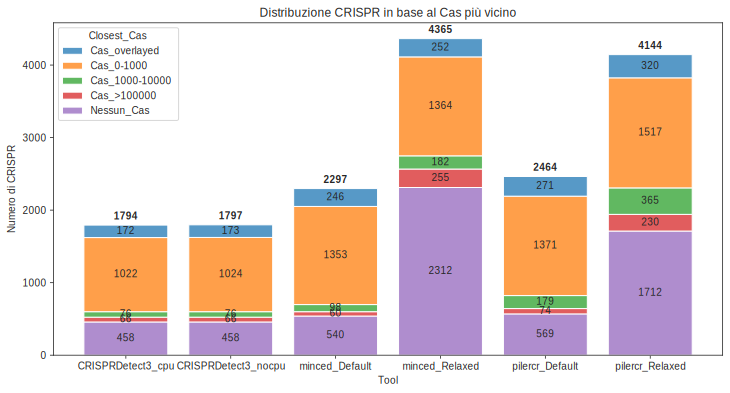

In [7]:
# CAS PIU VICINO

# Creiamo una funzione per assegnare il range più vicino
def assign_nearest_cas(row):
    cas_ranges = {
        'Cas_overlayed': row['Cas_overlayed'],
        'Cas_0-1000': row['Cas_0-1000'],
        'Cas_1000-10000': row['Cas_1000-10000'],
        'Cas_>100000': row['Cas_>100000']
    }
    
    # Filtriamo solo quelli con valore positivo (> 0)
    cas_ranges = {k: v for k, v in cas_ranges.items() if v > 0}
    
    if cas_ranges:
        return min(cas_ranges, key=lambda k: ['Cas_overlayed', 'Cas_0-1000', 'Cas_1000-10000', 'Cas_>100000'].index(k))
    else:
        return 'Nessun_Cas'  # Se non c'è nessun Cas vicino

# Applichiamo la funzione al dataframe per creare la nuova colonna
df_exploded['Closest_Cas'] = df_exploded.apply(assign_nearest_cas, axis=1)

# ordiniamo in base al cas_range
df_exploded['Closest_Cas'] = pd.Categorical(df_exploded['Closest_Cas'])
df_exploded['Closest_Cas'] = df_exploded['Closest_Cas'].cat.reorder_categories(['Cas_overlayed', 'Cas_0-1000', 'Cas_1000-10000', 'Cas_>100000', 'Nessun_Cas'], ordered=True)

plt.figure(figsize=(12, 6))

# Ora possiamo fare il grafico con Seaborn usando la colonna 'Closest_Cas'
ax = sns.histplot(data=df_exploded, x='ToolCodename', hue='Closest_Cas', multiple="stack", shrink=0.8, legend=True)

# Aggiungere i totali sopra le barre
totals = df_exploded.groupby('ToolCodename').size()
for i, tool in enumerate(totals.index):
    total_count = totals[tool]
    ax.text(i, total_count + 50, f'{total_count}', ha='center', va='bottom', fontweight='bold')

# Aggiungere le etichette sopra ogni barra
for bars in ax.containers:
    ax.bar_label(bars, fmt='%.0f', label_type='center', padding=0)


plt.title('Distribuzione CRISPR in base al Cas più vicino')
plt.xlabel('Tool')
plt.ylabel('Numero di CRISPR')
plt.savefig(f'{dir_save}/CRISPR_Closest_Cas.png', bbox_inches='tight')
plt.show()


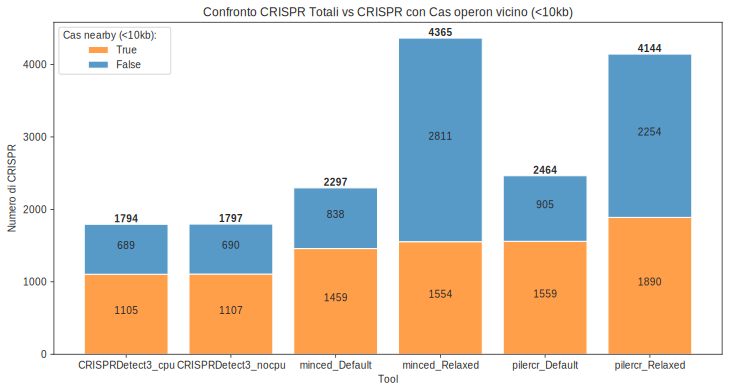

In [8]:
# CONFRONTO CRISPR TOTALI VS CRISPR CON CAS OPERON VICINO

# Crea il barplot
plt.figure(figsize=(12, 6))
ax=sns.histplot(data=df_exploded, x='ToolCodename', hue='Nearby_Cas', multiple="stack", shrink=0.8, legend=True)
# Aggiungere i totali sopra le barre
totals = df_exploded.groupby('ToolCodename').size()
for i, tool in enumerate(totals.index):
    total_count = totals[tool]
    ax.text(i, total_count + 0.5, f'{total_count}', ha='center', va='bottom', fontweight='bold')
# Aggiungere il numero per ogni barra
for bars in ax.containers:
    ax.bar_label(bars, fmt='%.0f', label_type='center', padding=3)

plt.title('Confronto CRISPR Totali vs CRISPR con Cas operon vicino (<10kb)')
plt.xlabel('Tool')
plt.ylabel('Numero di CRISPR')
# plt.xticks(rotation=45)
plt.legend(title='Cas nearby (<10kb):', labels=['True', 'False'])
# sns.despine()
# save the plot
plt.savefig(f'{dir_save}/CRISPR_totali_vs_CRISPR_cas_operon_vicino.png', bbox_inches='tight')
plt.show()

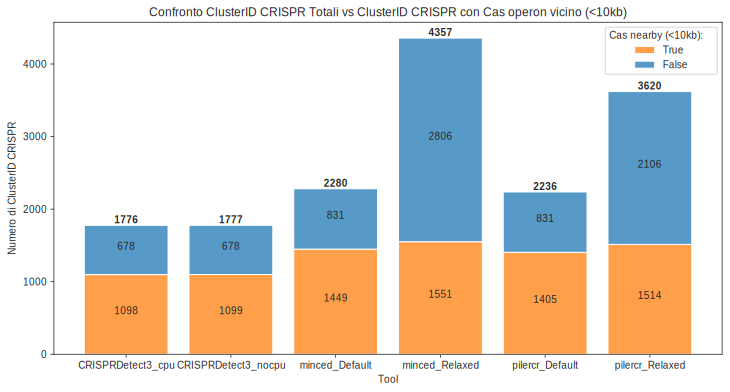

In [9]:
# CONFRONTO ClusterID CRISPR TOTALI VS ClusterID CRISPR CON CAS OPERON VICINO

# Crea il barplot
plt.figure(figsize=(12, 6))
ax=sns.histplot(data=df_id_exploded, x='ToolCodename', hue='Nearby_Cas', multiple="stack", shrink=0.8, legend=True)
# Aggiungere i totali sopra le barre
totals = df_id_exploded.groupby('ToolCodename').size()
for i, tool in enumerate(totals.index):
    total_count = totals[tool]
    ax.text(i, total_count + 0.5, f'{total_count}', ha='center', va='bottom', fontweight='bold')
# Aggiungere il numero per ogni barra
for bars in ax.containers:
    ax.bar_label(bars, fmt='%.0f', label_type='center', padding=3)

plt.title('Confronto ClusterID CRISPR Totali vs ClusterID CRISPR con Cas operon vicino (<10kb)')
plt.xlabel('Tool')
plt.ylabel('Numero di ClusterID CRISPR')
# plt.xticks(rotation=45)
plt.legend(title='Cas nearby (<10kb):', labels=['True', 'False'])
# sns.despine()
# save the plot
plt.savefig(f'{dir_save}/ClusterID_CRISPR_totali_vs_cas_operon_vicino.png', bbox_inches='tight')
plt.show()

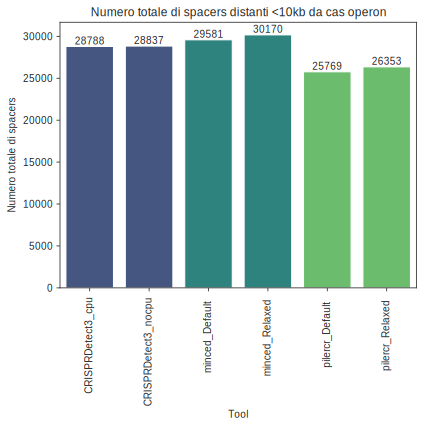

In [11]:
# CAS OPERONS

# Creo una serie con il numero di spacer che sono vicini ai cas operon (entro 10kb) per ogni tool
total_spacer = df_cas[tools].sum()

# Hist plot dei numeri di spacers distanti <10000bp dai cas operons per ogni tool
palette = sns.color_palette("viridis", len(total_spacer)//2)
colors = [palette[i//2] for i in range(len(total_spacer))]
ax=sns.barplot(x=total_spacer.index, y=total_spacer.values, palette=colors, hue=total_spacer.index)
plt.xticks(rotation=90)
for a in ax.containers:
    ax.bar_label(a)
plt.title('Numero totale di spacers distanti <10kb da cas operon')
plt.ylabel('Numero totale di spacers')
plt.xlabel('Tool')
plt.savefig(f'{dir_save}/Numero_totale_spacers_cas_operon.png', bbox_inches='tight')
plt.show()

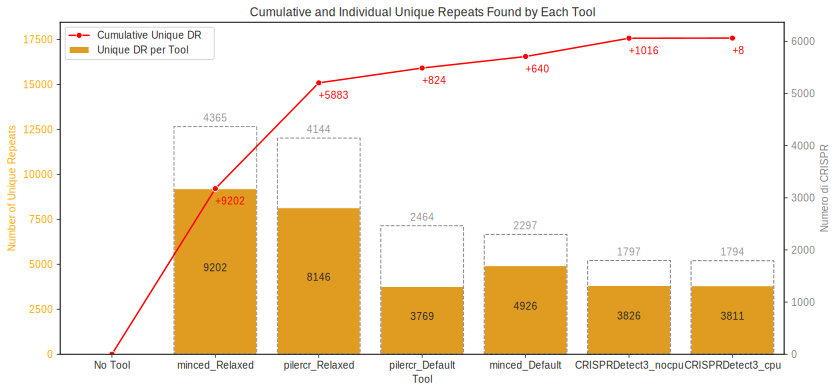

In [12]:
# Unique DR per ogni tool

# Numero di CRISPR trovati da ogni tool
crispr_counts = df_exploded['ToolCodename'].value_counts().sort_values(ascending=False)

# Ordina df_exploded per ToolCodename in base al numero di CRISPR trovati
df_exploded = df_exploded.sort_values(by='ToolCodename')

# Calcolare gli unique repeats cumulativi
unique_DR_cumulative = []
# Set cumulativo per tenere traccia dei repeat unici
cumulative_set = set()

# Punto di partenza: 0 repeats, prima di aggiungere qualsiasi tool
unique_DR_cumulative.append({
    'Tool': 'No Tool',
    'Unique_DR': 0,
    'Added_DR': 0
})

unique_DR_counts_per_tool = {}

for tool in crispr_counts.index:
    # Ottieni i repeat trovati da questo tool
    repeats = df_exploded.loc[df_exploded['ToolCodename'] == tool, 'Unique_DR'].values
    flattened_list = [item for subset in repeats for item in subset]
    
    # Aggiungi i nuovi repeat al set cumulativo
    prev_count = len(cumulative_set)
    cumulative_set.update(flattened_list)
    current_count = len(cumulative_set)
    
    # Calcola il numero di repeat aggiunti rispetto al tool precedente
    added_dr = current_count - prev_count

    # Aggiorna la lista cumulativa
    unique_DR_cumulative.append({
        'Tool': tool,
        'Unique_DR': current_count,
        'Added_DR': added_dr
    })
    
    # Conta i repeat unici trovati solo da questo tool
    unique_DR_counts_per_tool[tool] = len(set(flattened_list))

# Converti in DataFrame per il grafico cumulativo
cumulative_df = pd.DataFrame(unique_DR_cumulative)

# Converti in DataFrame per il grafico a barre
bar_df = pd.DataFrame(list(unique_DR_counts_per_tool.items()), columns=['Tool', 'Unique_DR_Count'])

# Creare il grafico combinato sullo stesso asse
fig, ax = plt.subplots(figsize=(13, 6))

# Grafico a linee per unique repeats cumulativi
sns.lineplot(data=cumulative_df, x='Tool', y='Unique_DR', marker='o', ax=ax, color='red', label='Cumulative Unique DR', legend='full')
# Aggiungere etichette sopra i punti della linea
for i in range(1, len(cumulative_df)):
    tool = cumulative_df.loc[i, 'Tool']
    unique_dr = cumulative_df.loc[i, 'Unique_DR']
    added_dr = cumulative_df.loc[i, 'Added_DR']
    ax.text(i, unique_dr - 1000, f'+{added_dr}', ha='left', va='bottom', fontsize=10, color='red')

# Grafico a barre per unique repeats per tool
ax = sns.barplot(data=bar_df, x='Tool', y='Unique_DR_Count', alpha=1, ax=ax, color='orange', label='Unique DR per Tool', legend='full')
ax.set_ylabel('Unique DR per Tool', color='orange')
ax.tick_params(axis='y', labelcolor='orange')
# Aggiungere i totali dentro le barre
for bars in ax.containers:
    ax.bar_label(bars, fmt='%.0f', label_type='center', padding=3)

# Secondo asse per il grafico a barre
ax1 = ax.twinx()
ax1=sns.barplot(x=crispr_counts.index, y=crispr_counts.values, palette='dark:black', hue=crispr_counts.index, alpha=0.5, ax=ax1, fill=False, label='Numero di CRISPR', linestyle='--', linewidth=1)
ax1.set_ylabel('Numero di CRISPR', color='black', alpha=0.5)
ax1.tick_params(axis='y', labelcolor='grey')
# Aggiungere i totali sopra le barre
for bars in ax1.containers:
    ax1.bar_label(bars, fmt='%.0f', label_type='edge', padding=3, alpha=0.5)

# Impostare etichette e titolo
ax.set_ylabel('Number of Unique Repeats')
ax.set_xlabel('Tool')
ax.set_title('Cumulative and Individual Unique Repeats Found by Each Tool')
# ax.grid(True)
plt.xticks(rotation=45)
# plt.legend()

# Sincronizzare la scala sull'asse Y
# max_y_value = max(cumulative_df['Unique_DR'].max(), bar_df['Unique_DR_Count'].max())
# ax.set_ylim(0, max_y_value + 500)
ax1.set_ylim(0, max(crispr_counts.values) + 2000)

plt.savefig(f'{dir_save}/Unique_DR_cumulative_and_individual.png', bbox_inches='tight')
plt.show()


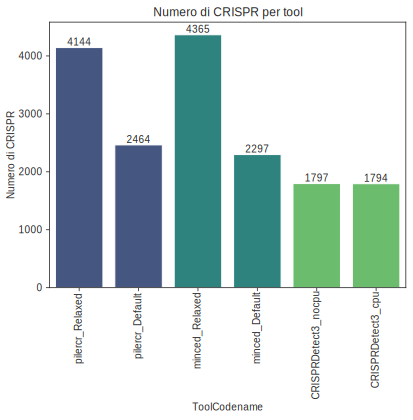

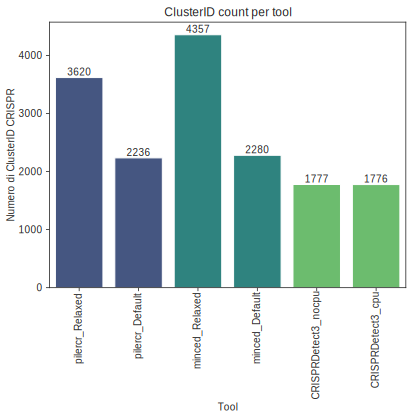

In [8]:
# N. CRISPR per tool
crispr_counts = df_exploded['ToolCodename'].value_counts().sort_index(ascending=False)
palette = sns.color_palette("viridis", len(crispr_counts)//2)
colors = [palette[i//2] for i in range(len(crispr_counts))]
ax=sns.barplot(x=crispr_counts.index, y=crispr_counts.values, palette=colors, hue=crispr_counts.index)
plt.title('Numero di CRISPR per tool')
plt.ylabel('Numero di CRISPR')
plt.xticks(rotation=90)
for a in ax.containers:
    ax.bar_label(a)
plt.savefig(f'{dir_save}/CRISPR_count_per_tool.png', bbox_inches='tight')
plt.show()

# N. di Cluster ID per tool
id_counts = df_id_exploded.groupby('ToolCodename').size().sort_index(ascending=False)
palette = sns.color_palette("viridis", len(id_counts) // 2)
colors = [palette[i // 2] for i in range(len(id_counts))]
ax=sns.barplot(x=id_counts.index, y=id_counts.values , palette=colors, hue=id_counts.index)
plt.title('ClusterID count per tool')
plt.ylabel('Numero di ClusterID CRISPR')
plt.xlabel('Tool')
plt.xticks(rotation=90)
for a in ax.containers:
    ax.bar_label(a)
plt.savefig(f'{dir_save}/ClusterID_count_per_tool.png', bbox_inches='tight')
plt.show()

/usr/local/Caskroom/miniconda/base/envs/CRISPR-transmission/lib/python3.12/site-packages/upsetplot/data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/usr/local/Caskroom/miniconda/base/envs/CRISPR-transmission/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operati

<Figure size 3000x3000 with 0 Axes>

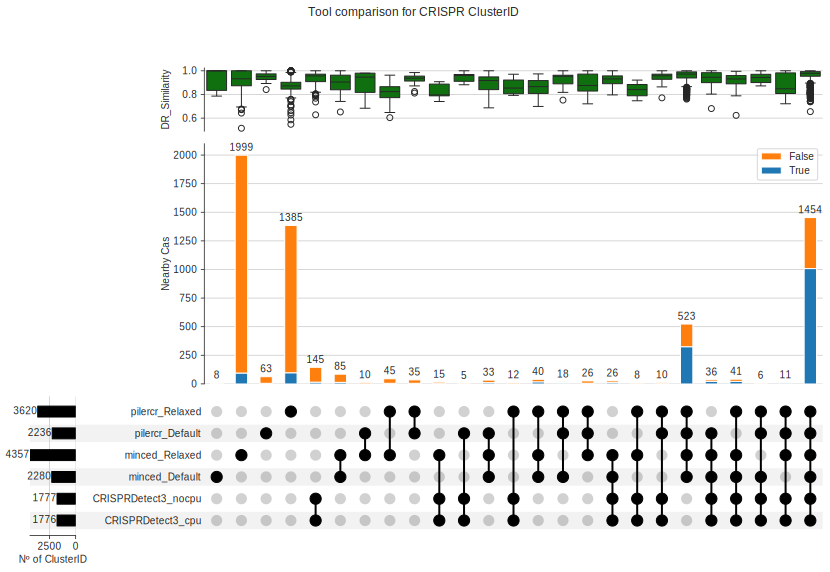

In [25]:
# UPSET PLOT raggruppando per Cluster ID

# Genera i dati per l'upset plot
df_id_upset = from_memberships(df_id.ToolCodename.str.split(","), data=df_id)
plt.figure(figsize=(10, 10))

# Genera un UpSet plot con i conteggi
upset=UpSet(df_id_upset, subset_size='count', show_counts=True, min_subset_size=5, sort_categories_by="input", intersection_plot_elements=0)

# upset.style_subsets(present=["minced_Paper", "minced_Default"], max_degree=2, min_degree=1, facecolor="blue")
# upset.style_subsets(present="minced_Paper", facecolor="blue")
# upset.add_catplot(value="Cas_0-10000", kind="box", color="red")
upset.add_stacked_bars(by="Nearby_Cas", title="Nearby Cas", elements=10)
upset.add_catplot(value="DR_Similarity", kind="box", color="green")
# upset.add_catplot(value="Nearby_Cas", kind="bar", color="green")

upset_plot = upset.plot()
# upset_plot["intersections"].set_ylabel("Subset size")
upset_plot["totals"].set_xlabel("Nº of ClusterID")
plt.suptitle("Tool comparison for CRISPR ClusterID")
plt.savefig(f'{dir_save}/Upset_plot_ClusterID.png', bbox_inches='tight')
plt.show()

/usr/local/Caskroom/miniconda/base/envs/CRISPR-transmission/lib/python3.12/site-packages/upsetplot/data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/usr/local/Caskroom/miniconda/base/envs/CRISPR-transmission/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operati

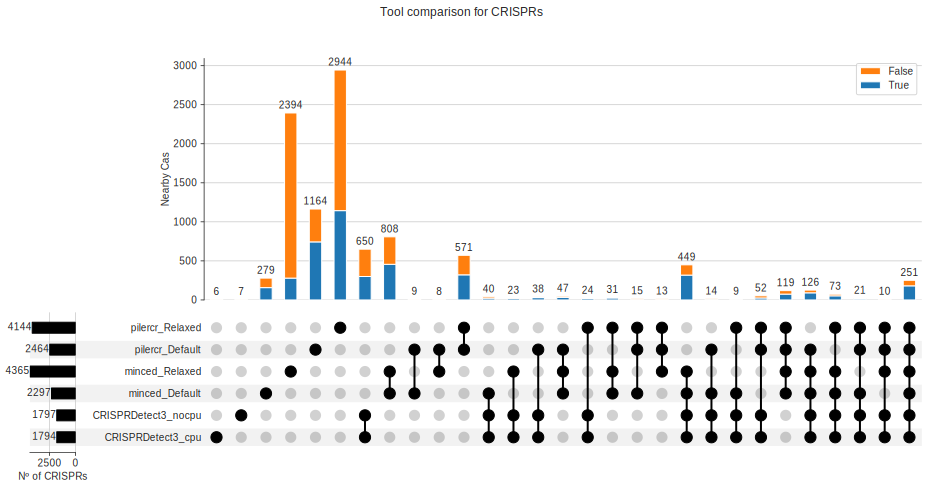

In [9]:
# UPSET PLOT

# Genera i dati per l'upset plot
df_upset = from_memberships(df.ToolCodename.str.split(","), data=df)

# Genera un UpSet plot con i conteggi
upset=UpSet(df_upset, subset_size='count', show_counts=True, min_subset_size=5, sort_categories_by="input", intersection_plot_elements=0)

upset.add_stacked_bars(by="Nearby_Cas", title="Nearby Cas", elements=10)
# upset.style_subsets(present=["minced_Paper", "minced_Default"], max_degree=2, min_degree=1, facecolor="blue")
# upset.style_subsets(present="minced_Paper", facecolor="blue")
# upset.add_catplot(value="max_DR_len", kind="strip", color="red")

upset_plot = upset.plot()
# upset_plot["intersections"].set_ylabel("Subset size")
upset_plot["totals"].set_xlabel("Nº of CRISPRs")
plt.suptitle("Tool comparison for CRISPRs")
plt.savefig(f'{dir_save}/Upset_plot_CRISPR.png', bbox_inches='tight')
plt.show()

In [ ]:
# UPSET PLOT con tool selezionati
from upsetplot import UpSet,  generate_counts, from_indicators

# Crea un dataframe con colonne per ogni tool e True/False
tool_indicator = pd.DataFrame(
    [{cat: True for cat in cats} for cats in df.ToolCodename.str.split(",").values]
).fillna(False)


# Aggiunge le colonne degli indicatori al dataframe originale
df_upset = pd.concat([df, tool_indicator], axis=1)

# Crea un dataframe per l'UpSet che ha come indice i valori delle colonne selezionate
df_upset = from_indicators(
    #["minced_Default", "minced_Paper", "pilercr_PILER1", "pilercr_PILER2", "CRISPRDetect3"]
    ["CRISPRDetect3", "CRISPRDetect3_online", "CRISPRDetect3_cpu", "CRISPRDetect3_nocpu"],#, "CRISPRDetect2", "CRISPRDetect2_cpu", "CRISPRDetect2_nocpu"],
    data=df_upset
)

# Genera un UpSet plot con i conteggi
upset = UpSet(df_upset, subset_size='count', show_counts=True, max_subset_size=500, intersection_plot_elements=1)
upset.add_catplot(value="max_DR_len", kind="strip", color="red")
upset_plot = upset.plot()
upset_plot["intersections"].set_ylabel("Subset size")
upset_plot["totals"].set_xlabel("Nº of CRISPRs")
plt.suptitle("Tool comparison")
plt.show()

In [ ]:
# Diagramma di venn con pyvenn (2-6), 
from venn import venn

# Seleziona i tool che ti interessano
# tools_of_interest = ['pilercr_PILER1', 'minced_Paper', 'CRISPRDetect2', 'CRISPRDetect3']
# tools_of_interest = ['CRISPRDetect3', 'CRISPRDetect3_online', 'CRISPRDetect3_cpu', 'CRISPRDetect3_nocpu']
tools_of_interest = tools[:4]

# Crea un dizionario di set dove le chiavi sono i tool e i valori sono i set di ID per ogni tool
tool_sets_id = {}
for tool in tools_of_interest:
    tool_sets_id[tool] = set(df_exploded[df_exploded['ToolCodename'] == tool]['ID'])

# Crea un dizionario di set dove le chiavi sono i tool e i valori sono i set di index per ogni tool
tool_sets_index = {}
for tool in tools_of_interest:
    tool_sets_index[tool] = set(df_exploded[df_exploded['ToolCodename'] == tool].index)

# # Itera su ogni chiave e calcola la dimensione del set
# for key, value in tool_sets_index.items():
#     print(f"La chiave '{key}' ha {len(value)} elementi.")
# print('\n')
# # Itera su ogni chiave e calcola la dimensione del set
# for key, value in tool_sets_id.items():
#     print(f"La chiave '{key}' ha {len(value)} elementi.")

# Crea il grafico di Venn
venn(tool_sets_id)
plt.title('ID Venn diagram')
plt.show()

venn(tool_sets_index)
plt.title('Index Venn diagram')
plt.show()


In [ ]:
# Statistiche per Tool
for tool in tools:
    for stat in stats:
        sns.histplot(df_exploded[df_exploded['ToolCodename'] == tool][stat], kde=True)
        plt.title(f'{stats[stat]} per {tool}')
        plt.xlabel(stats[stat])
        # plt.yscale('log') # Con scala logaritmica
        plt.show()

In [ ]:
# Statistiche globali
for stat in stats:
    sns.histplot(df[stat], kde=True)
    plt.title(f'{stats[stat]}')
    plt.xlabel(stats[stat])
    # plt.yscale('log') # Con scala logaritmica
    plt.show()

In [ ]:
# Visualizzione dei dati divisa per ToolCodename con Boxplot

y = list(stats.items())[0]
# median_DR_len         0   lunghezza mediana dei DR
# median_SP_len         1   lunghezza mediana degli SP
# min_DR_len            2   lunghezza minima dei DR
# max_DR_len            3   lunghezza massima dei DR
# min_SP_len            4   lunghezza minima degli SP
# max_SP_len            5   lunghezza massima degli SP
# std_DR_len            6   deviazione standard DR
# std_SP_len            7   deviazione standard SP
# cv_DR_len             8   coefficiente variazione DR
# cv_SP_len             9   coefficiente variazione SP
# minmax_DR_ratio       10  rapporto lunghezza min/max DR

# Applica un tema estetico di Seaborn
# sns.set_theme(style="whitegrid", palette="muted")

# Crea la figura e l'asse
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))  # Ridotto l'altezza per renderlo meno schiacciato

# Boxplot per visualizzare la distribuzione della lunghezza mediana dei DR
sns.boxplot(data=df_exploded, x='ToolCodename', y=y[0], color='white', 
            flierprops={'alpha':0}, medianprops={'color':'k'}, linewidth=1.5, width=0.6)

# Stripplot per visualizzare i singoli punti, con un colore più brillante
sns.stripplot(data=df_exploded, ax=ax, x='ToolCodename', y=y[0], hue='Nearby_Cas', 
              alpha=0.7, jitter=0.25, size=3, legend=True)


# Migliora l'estetica generale
sns.despine()

# Personalizzazione delle etichette
ax.set_xlabel('Tool', size=13, labelpad=15)
ax.set_ylabel(y[1], size=13, labelpad=10)
ax.set_title(y[1], size=14, weight='bold')

# Ruota le etichette per una migliore leggibilità
plt.xticks(rotation=45, ha='right', size=11)  # Rotazione a 45 gradi con allineamento a destra

# Personalizza le etichette sull'asse Y
for x in ax.get_yticklabels():
    x.set_size(12)
# aumenta i tick sull'asse y
ax.yaxis.set_major_locator(plt.MaxNLocator(15))
# Migliora lo spessore delle spine e dei tick
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.tick_params(width=1.5, length=6)  # Tick più lunghi

# Opzionalmente, puoi settare i limiti dell'asse Y per focalizzare i dati (decommenta se serve)
# ax.set_ylim(0, 1)

# Mostra il grafico
plt.tight_layout()  # Per evitare sovrapposizioni
# save the plot
plt.savefig(f'{dir_save}/stats/{y[0]}_per_tool.png')
plt.show()
